# Fruit Classification

## Kaggle APIs

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


## Dowload Dataset

In [ ]:
!kaggle competitions download -c durian-hackathon-fruit-classification

durian-hackathon-sugarcane-disease-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/durian-hackathon-fruit-classification.zip

Archive:  /content/durian-hackathon-sugarcane-disease-classification.zip
  inflating: Images/0011691fb92ddb18f545a8cb97a0e1eb.jpeg  
  inflating: Images/002a24b5b60750b46a7f2e22d44139fe.jpeg  
  inflating: Images/00453f74178d09b585be5ac352125ec9.jpeg  
  inflating: Images/004b7c2dcc19c506caaf0467b1f8c9be.jpeg  
  inflating: Images/00594f0fd279eb20f862911424b1994a.jpeg  
  inflating: Images/005d7bb7158d38ecd495e34f189ffbbc.jpeg  
  inflating: Images/0079a8d9b1f30a3f49e9af7a4d6ac67c.jpeg  
  inflating: Images/0090430a9b9f7ab02a6887c376315a34.jpeg  
  inflating: Images/00bebb110cd8d1e2ddccef1747988dfc.jpeg  
  inflating: Images/00c79b3bcb4ea7045376a910079f5a08.jpeg  
  inflating: Images/00c82d29662622ec78b2f912a2d6fcdf.jpeg  
  inflating: Images/00d0acafd45fc90a9eb366d38289d189.jpeg  
  inflating: Images/00dbf27a320d4f6eae355a9e65f91c47.jpeg  
  inflating: Images/00e50694be7a798b3932353edf87648d.jpeg  
  inflating: Images/0119a779e27c7a775a1fa53d48d16cba.jpeg  
  inflating: Images/0120dee

## EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [6]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission_df = pd.read_csv('/content/submit.csv')

In [7]:
sample_submission_df.head()

,id,predict
0,15d0f4082d31554c2b1a7a269124b1fe.jpeg,3.0
1,8d78c00b23c02defce91dce96090939a.jpeg,1.0
2,a973d96257b32b6e378746daa6810118.jpeg,3.0
3,d0c736be3f8c84be2a1cb0a210f76aeb.jpeg,1.0
4,3fae5d3beed153f10dbe220365470787.jpeg,1.0


In [8]:
train_df.head()

,id,label
0,54bac4cf8fd8d5b983d643ee72fdb771.jpeg,0
1,2b73198d2f6b8ed16e55eaa7aa0da80f.jpeg,3
2,9e458c89e38ecdb0afced8bde29f3db8.jpeg,0
3,284977db3c71d9ac3e90c7f9babb19f9.jpeg,3
4,4050f0ff0f6154ca70a2e92762855435.jpeg,0


In [9]:
test_df.head()

,id
0,15d0f4082d31554c2b1a7a269124b1fe.jpeg
1,8d78c00b23c02defce91dce96090939a.jpeg
2,a973d96257b32b6e378746daa6810118.jpeg
3,d0c736be3f8c84be2a1cb0a210f76aeb.jpeg
4,3fae5d3beed153f10dbe220365470787.jpeg


## Split Train / Test Files

In [10]:
import os
import shutil

In [11]:
!mkdir /content/train /content/test

mkdir: cannot create directory ‘/content/train’: File exists
mkdir: cannot create directory ‘/content/test’: File exists


In [12]:
def move_file(image_id , dst_folder):

    dst = f'{dst_folder}/{image_id}'
    src = f'/content/Images/{image_id}'

    if not os.path.exists(dst):
        shutil.move(src, dst)

    else:
        print(f"File {dst} already exists. Skipping.")

In [13]:
# Moving train images
for idx, row in train_df.iterrows():
    img_id = row['id']
    move_file(img_id, '/content/train')

# Moving test images
for idx, row in test_df.iterrows():
    img_id = row['id']
    move_file(img_id, '/content/test')


File /content/train/54bac4cf8fd8d5b983d643ee72fdb771.jpeg already exists. Skipping.
File /content/train/2b73198d2f6b8ed16e55eaa7aa0da80f.jpeg already exists. Skipping.
File /content/train/9e458c89e38ecdb0afced8bde29f3db8.jpeg already exists. Skipping.
File /content/train/284977db3c71d9ac3e90c7f9babb19f9.jpeg already exists. Skipping.
File /content/train/4050f0ff0f6154ca70a2e92762855435.jpeg already exists. Skipping.
File /content/train/f2043edca1438bccd4806fcc0c0781f9.jpeg already exists. Skipping.
File /content/train/1ed4d94d9255bec19bc43052d24f9b1a.jpeg already exists. Skipping.
File /content/train/86f09cf1244601f0bea5335a46091476.jpeg already exists. Skipping.
File /content/train/5d2b4871dbcfd18ddeeeeeff8144498c.jpeg already exists. Skipping.
File /content/train/a6ed092965fe69815a162b5cebdd0f7f.jpeg already exists. Skipping.
File /content/train/f8d7a81cb2f6a625f5f1ad2a3238842b.jpeg already exists. Skipping.
File /content/train/94ea588dd329b425a72dc1988fc0e6d3.jpeg already exists. Sk

## Sample Images

In [14]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
def get_random_files(folder_path, num_files):

    files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

    return random.sample(files, min(num_files, len(files)))

In [16]:
def get_random_images(folder_path , annotation_path , num_images = 9):

    annotations = pd.read_csv(annotation_path , index_col = 'id')
    selected_images = get_random_files(folder_path = folder_path , num_files = num_images)

    return selected_images , {img : annotations.loc[img]['label'] for img in selected_images}

In [17]:
get_random_files('/content/train' , 9)

['b99a389c7ef9630f1f2c45ad1117b3bf.jpeg',
 'dfbcd334da0cb4acb1345844742b27af.jpeg',
 'c97092f6d240853160aedfadfc9ad6b1.jpeg',
 '060b5dca0ef6fc7d9c4b982dda80e887.jpeg',
 '94beccdcddd8f843c9ed591a6ea0683c.jpeg',
 'a4ab19d0753e16312bb1412be60baab4.jpeg',
 '4ed314b3955794a6d204f1044a094f4f.jpeg',
 'e426ea630461bbce00fffa78cb73d81c.jpeg',
 '416411f897ef8a6329e6fd3d3124a006.jpeg']

In [18]:
get_random_images('/content/train' , '/content/train.csv' , 9)

(['c5b01b8dd991ee3122c7ba8097c5d3bb.jpeg',
  'b10a0f3302991f3ecdcaa7b263f32b12.jpeg',
  'e1dc63fb5ef080bb104d50c61028f55f.jpeg',
  'e7cc59fa55bbe8965939869adc457b36.jpeg',
  '06c21343eb2564e9739cb31a743700af.jpeg',
  '710e4baa4d3d73348185000795d88733.jpeg',
  '31b5df920c252a7bb57cfd132534baa6.jpeg',
  'eb40a65699330d5f1854c6c3de7c720b.jpeg',
  'b8ce1670073ba37a6011720868436cce.jpeg'],
 {'c5b01b8dd991ee3122c7ba8097c5d3bb.jpeg': 2,
  'b10a0f3302991f3ecdcaa7b263f32b12.jpeg': 3,
  'e1dc63fb5ef080bb104d50c61028f55f.jpeg': 4,
  'e7cc59fa55bbe8965939869adc457b36.jpeg': 2,
  '06c21343eb2564e9739cb31a743700af.jpeg': 1,
  '710e4baa4d3d73348185000795d88733.jpeg': 2,
  '31b5df920c252a7bb57cfd132534baa6.jpeg': 4,
  'eb40a65699330d5f1854c6c3de7c720b.jpeg': 4,
  'b8ce1670073ba37a6011720868436cce.jpeg': 2})

In [19]:
def display_image_grid(image_paths, labels, folder_path, grid_size=(3, 3)):
    """Displays selected images and their labels in a 3x3 grid using Matplotlib."""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            img = Image.open(os.path.join(folder_path, image_paths[i]))
            ax.imshow(img)
            ax.set_title(labels[image_paths[i]], fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [20]:
def display_image_grid_test(image_paths , folder_path , grid_size=(3, 3)):
    """Displays selected images and their labels in a 3x3 grid using Matplotlib."""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            img = Image.open(os.path.join(folder_path, image_paths[i]))
            ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### Sample Train Images

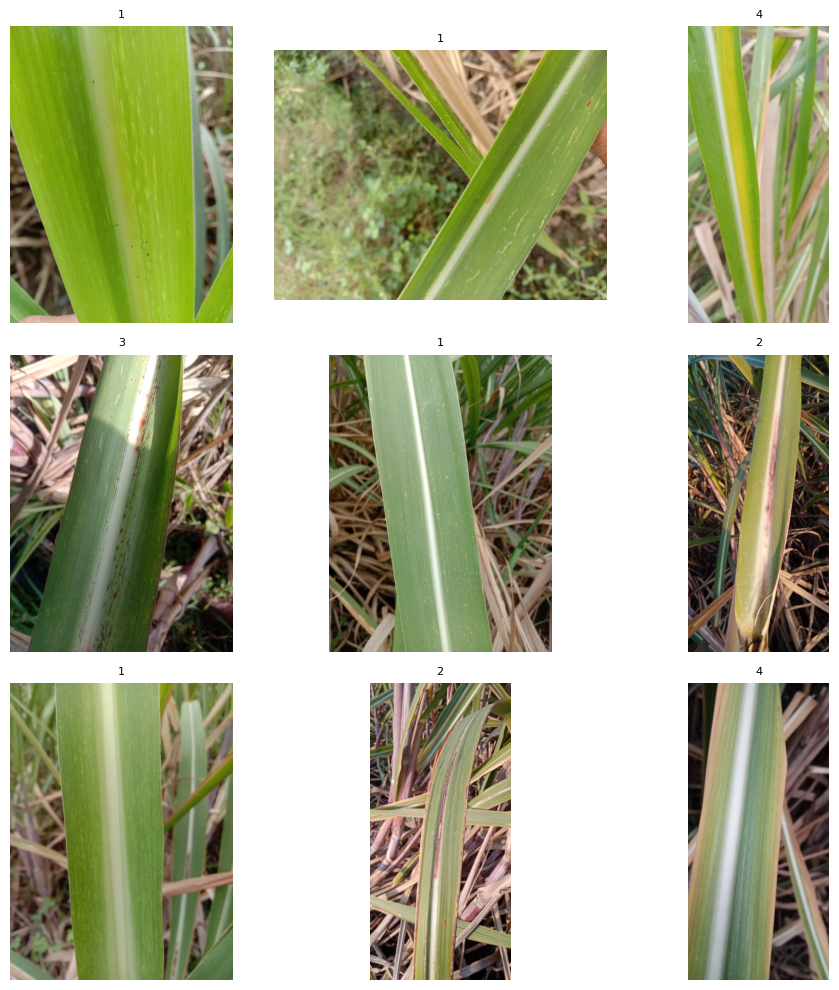

In [21]:
# Set folder path where images are stored and the annotation file
folder_path = "/content/train"  # Change this to your image directory
annotation_file = "/content/train.csv"  # Change this to your annotation JSON file

# Get random images and display them
random_images, image_labels = get_random_images(folder_path, annotation_file)
display_image_grid(random_images, image_labels, folder_path)

### Sample Test Images

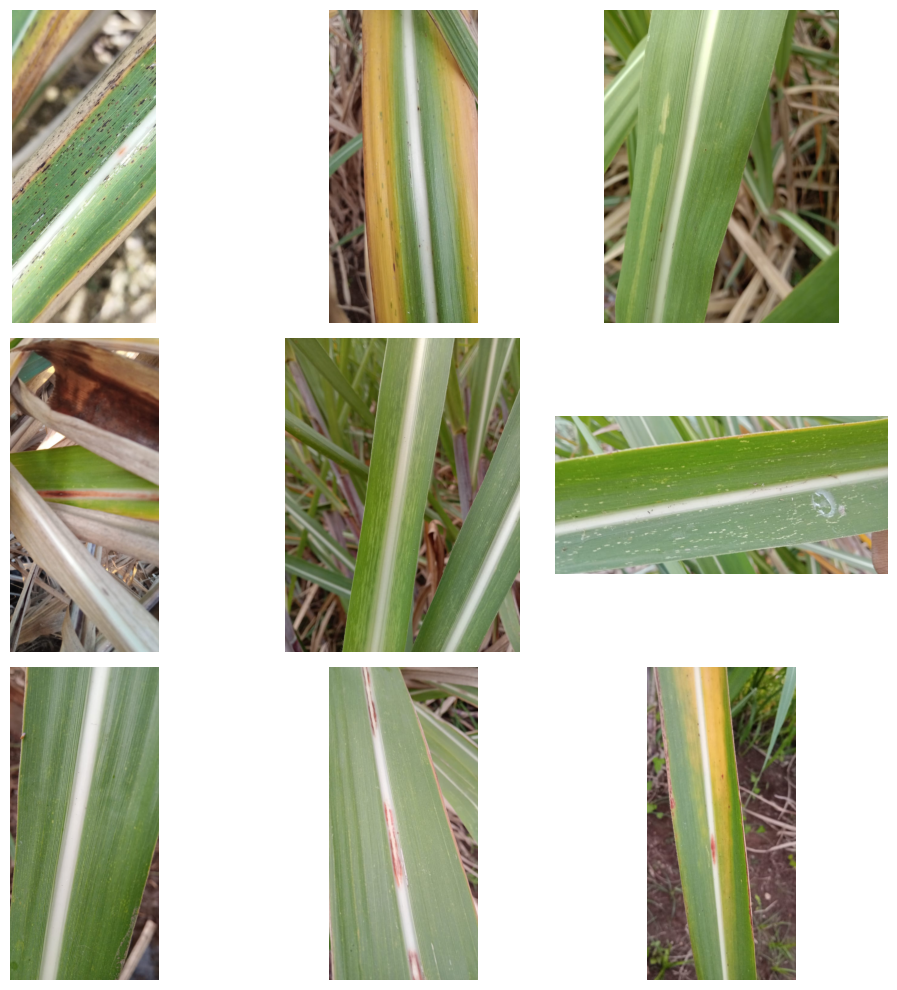

In [22]:
# Set folder path where images are stored and the annotation file
folder_path = "/content/test"  # Change this to your image directory

# Get random images and display them
random_images = get_random_files(folder_path , 9)
display_image_grid_test(random_images , folder_path)

## Augment Image

In [23]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [24]:
# Paths
images_folder = "/content/train"
csv_file = "/content/train.csv"

# Load the annotation file
df = pd.read_csv(csv_file)

# Define Augmentation Pipeline
augmentations = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomGamma(p=0.5),
    A.CLAHE(clip_limit=2.0, p=0.3),
]

transform = A.Compose(augmentations + [ToTensorV2()])

# Process each image
new_data = []
for _, row in df.iterrows():
    image_id = row["id"]
    label = row["label"]  # Ensure the CSV has a "label" column

    image_path = os.path.join(images_folder, image_id)
    if not os.path.exists(image_path):
        continue  # Skip missing images

    # Load Image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate Augmented Images
    for i in range(3):  # Change number of augmentations per image
        augmented = transform(image=image)["image"]

        # Convert tensor to numpy
        augmented = augmented.permute(1, 2, 0).numpy()

        # New Filename
        new_filename = f"{os.path.splitext(image_id)[0]}_aug{i+1}.jpg"
        new_path = os.path.join(images_folder, new_filename)

        # Save Augmented Image
        cv2.imwrite(new_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

        # Append new entry
        new_data.append({"id": new_filename, "label": label})

# Append new data to CSV
df_extended = pd.concat([df, pd.DataFrame(new_data)], ignore_index=True)

# Save updated CSV
df_extended.to_csv("/content/train.csv", index=False)

print(f"Data augmentation completed. Extended CSV saved as 'annotations_extended.csv' with {len(df_extended)} entries.")


Data augmentation completed. Extended CSV saved as 'annotations_extended.csv' with 7056 entries.


## Torch Lightning

In [25]:
!pip install pytorch-lightning

In [26]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pytorch_lightning as pl

In [27]:
# Custom Dataset
class PlantDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(self.annotations['label'].unique()))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx]['id'])
        image = Image.open(img_name).convert("RGB")
        label = self.label_mapping[self.annotations.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
# Load dataset
dataset = PlantDataset(csv_file="/content/train.csv", root_dir="/content/train", transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchvision import models

# Define Model using PyTorch Lightning
class PlantClassifier(pl.LightningModule):

    def __init__(self, num_classes):
        super().__init__()
        # Load ResNet-101 with pretrained weights
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

        # Replace the fully connected layer to match num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]


In [32]:
# Train the model
num_classes = len(dataset.label_mapping)
model = PlantClassifier(num_classes)
trainer = pl.Trainer(max_epochs=30, accelerator = "gpu" if torch.cuda.is_available() else "cpu")
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 42.5 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [33]:
from tqdm.notebook import tqdm

In [34]:
# Prediction function (Batch Inference with tqdm)
def predict_test_images(model, test_folder, output_csv, batch_size = 32):

    model.eval()
    test_images = [f for f in os.listdir(test_folder)]
    test_dataset = [os.path.join(test_folder, img) for img in test_images]

    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting", unit="batch"):
            images = [Image.open(img).convert("RGB") for img in batch]
            images = torch.stack([transform(img) for img in images])
            outputs = model(images)
            predicted_labels = outputs.argmax(dim=1).tolist()

            for img_path, label in zip(batch, predicted_labels):
                predictions.append({"id": os.path.basename(img_path) , "predict": label})

    df = pd.DataFrame(predictions)
    df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

In [35]:
# Predict on test set and save results
test_folder = "/content/test"
output_csv = "/content/submission.csv"
predict_test_images(model, test_folder, output_csv)

Predicting:   0%|          | 0/24 [00:00<?, ?batch/s]

Predictions saved to /content/submission.csv


In [36]:
submission_df = pd.read_csv('/content/submission.csv' , index_col = 'id')

In [37]:
submission_df.loc['a973d96257b32b6e378746daa6810118.jpeg']

,a973d96257b32b6e378746daa6810118.jpeg
predict,3


In [ ]:
!kaggle competitions submit -c durian-hackathon-fruit-classification -f /content/submission.csv -m "Resnet-50"

100% 29.6k/29.6k [00:00<00:00, 83.7kB/s]
Successfully submitted to Durian Hackathon: Sugarcane Disease Classification

In [ ]:
!kaggle competitions submissions -c durian-hackathon-fruit-classification

fileName              date                 description  status    publicScore  privateScore  
--------------------  -------------------  -----------  --------  -----------  ------------  
submission.csv        2025-02-15 07:26:15  Resnet-50    complete  0.97635                    
mixed_submission.csv  2025-02-15 07:12:10               complete  0.93371                    
submission.csv        2025-02-15 07:11:19  Resnet-50    complete  0.95993                    
mixed_submission.csv  2025-02-15 07:11:05               error                                
mixed_submission.csv  2025-02-15 07:08:53               complete  0.47066                    
mixed_submission.csv  2025-02-15 07:06:43  Super Power  error                                
submission.csv        2025-02-15 07:01:45  Resnet-50    complete  0.93871                    
submission.csv        2025-02-15 06:57:38  Resnet-50    complete  0.94420                    
submission.csv        2025-02-15 06:51:18  Resnet-50    comp